In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import mglearn
import warnings

warnings.filterwarnings('ignore') 
plt.style.use('classic')

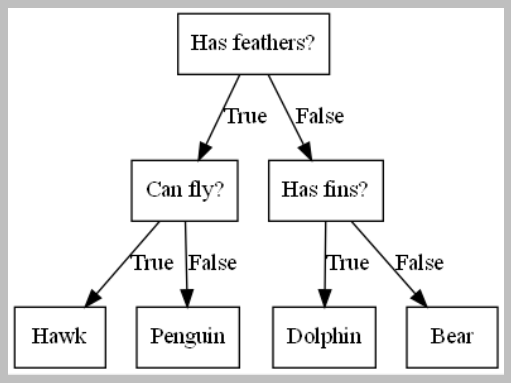

In [2]:
mglearn.plots.plot_animal_tree()

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer

def showShape(X,y) :
    print('X shape : ', X.shape)
    print('y shape : ', y.shape)

cancer = load_breast_cancer()
showShape(cancer.data, cancer.target)
print("target : ", np.unique(cancer.target))




X shape :  (569, 30)
y shape :  (569,)
target :  [0 1]


In [11]:
# DecisionTreeClassifier에 매개변수를 따로 할당하지 않으면
# 모든 리프노드가 순수노드가 될 때까지 학습한다.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target,
                                                    stratify= cancer.target, random_state=42)
tree = DecisionTreeClassifier(random_state = 0).fit(X_train, y_train)

print(f"train score : {tree.score(X_train, y_train):0.4f}")
print(f"test score : {tree.score(X_test, y_test):0.4f}")

train score : 1.0000
test score : 0.9371


In [13]:
# 최대 깊이를 설정하여 복잡도를 제어한다.

tree = DecisionTreeClassifier(max_depth=4, random_state = 0).fit(X_train, y_train)

print(f"train score : {tree.score(X_train, y_train):0.4f}")
print(f"test score : {tree.score(X_test, y_test):0.4f}")


train score : 0.9883
test score : 0.9510


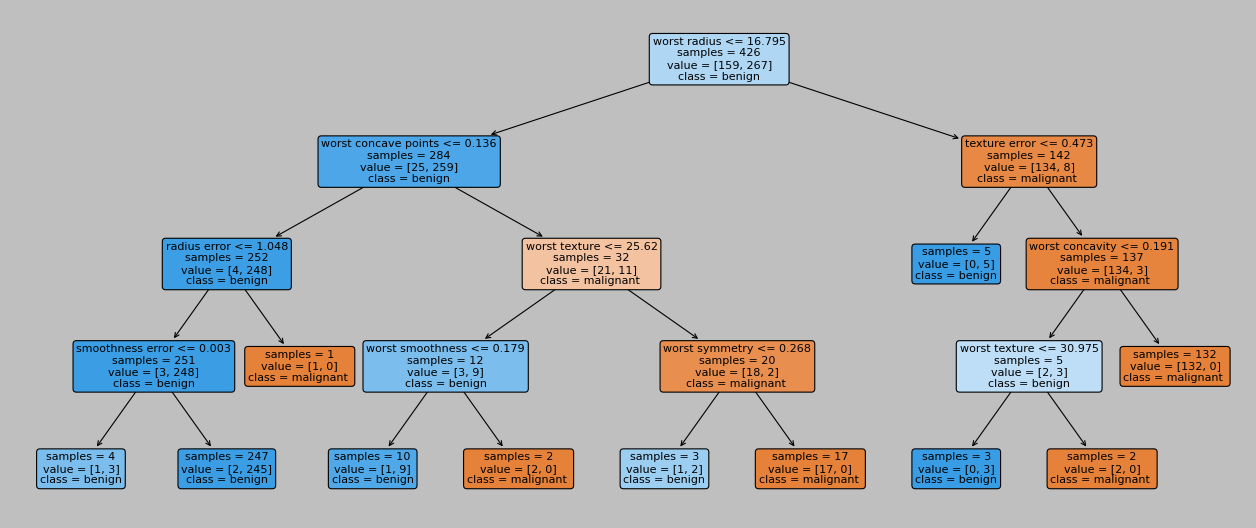

In [25]:
from sklearn.tree import plot_tree
plt.figure(figsize = (20,8))
plot_tree(tree, class_names = ['malignant ', 'benign'], feature_names=cancer.feature_names,
          impurity = False, filled = True, rounded=True, fontsize=10)
plt.show()

In [27]:
print("특성 중요도 :\n", tree.feature_importances_)

특성 중요도 :
 [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01019737 0.04839825
 0.         0.         0.0024156  0.         0.         0.
 0.         0.         0.72682851 0.0458159  0.         0.
 0.0141577  0.         0.018188   0.1221132  0.01188548 0.        ]


#### feature importance가 낮다고 하여 이 특성이 꼭 유효하지 않은 것은 아님
#### 단지 결정 트리가 해당 특성을 선택하지 않았을 뿐이고, 다른 특성이 동일한 정보를 지니고 있어서일 수 있다.

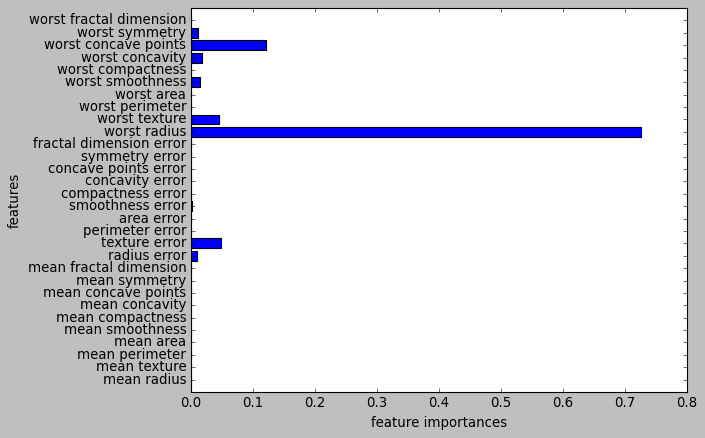

In [31]:
def plot_feature_importances_cancer(model) :
    n_features = cancer.data.shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("feature importances")
    plt.ylabel("features")
    plt.ylim(-1,n_features)
plot_feature_importances_cancer(tree)

### 트리기반 회귀 모델을 사용시 주의사항
#### 본래 데이터의 범위를 넘어가는 값에 대해서는 예측할 수 없음 

In [38]:
import os

ram_prices = pd.read_csv(os.path.join(mglearn.datasets.DATA_PATH, "ram_price.csv"))
ram_prices.head()

,Unnamed: 0,date,price
0,0,1957.0,411041792.0
1,1,1959.0,67947725.0
2,2,1960.0,5242880.0
3,3,1965.0,2642412.0
4,4,1970.0,734003.0


Text(0, 0.5, 'price')

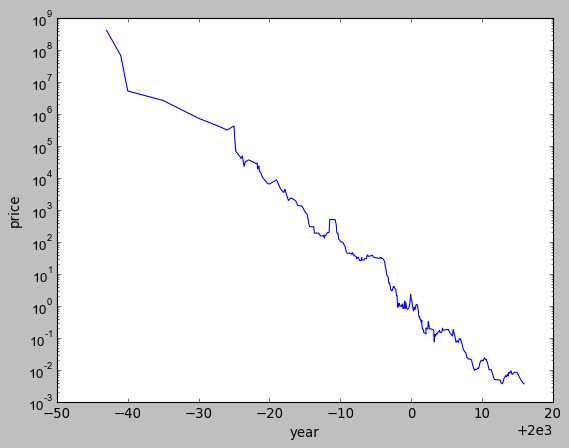

In [39]:

plt.yticks(fontname = 'Arial')
plt.semilogy(ram_prices.date, ram_prices.price)
plt.xlabel("year")
plt.ylabel("price")

In [58]:
# decision tree는 feature scale 에 무관하지만 linear 은 feature scale을 조정해줘야한다.
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

data_train = ram_prices[ram_prices.date < 2000]
data_test = ram_prices[ram_prices.date >= 2000]

X_train = data_train.date.to_numpy().reshape(-1,1)
y_train = np.log(data_train.price)

tree = DecisionTreeRegressor().fit(X_train, y_train)
linear_leg = LinearRegression().fit(X_train, y_train)

X_all = ram_prices.date.to_numpy().reshape(-1,1)

pred_tree = tree.predict(X_all)
pred_lr = linear_leg.predict(X_all)

price_tree = np.exp(pred_tree)
price_lr = np.exp(pred_lr)

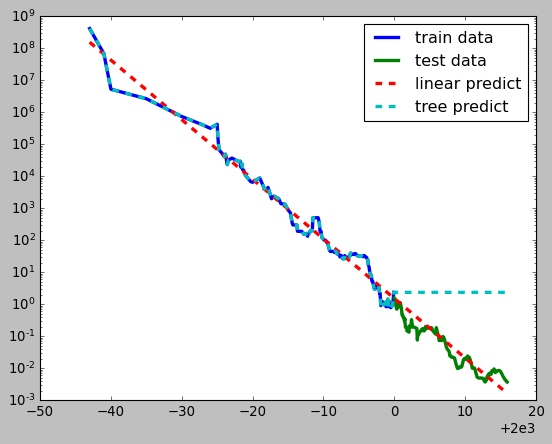

In [71]:
plt.semilogy(data_train.date, data_train.price, label = 'train data', linewidth = 3)
plt.semilogy(data_test.date, data_test.price, label = 'test data',linewidth = 3)
plt.semilogy(X_all, price_lr, label = 'linear predict',linewidth = 3, linestyle = '--')
plt.semilogy(X_all, price_tree, label = 'tree predict',linewidth = 3, linestyle = '--')
plt.legend()

(202, 1)